# STL-10 dataset의 VGG16 모델

**Baseline Model**


*   테스트 데이터셋 : 전체 8,000개 중 2,000개 적용
*   Batch size : 64 적용
*   Epoch : 5 적용



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import random

In [13]:
# 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# 데이터 준비 (STL10)(전체 테스트 데이터셋 적용)

  # STL10은 96x96 컬러 이미지 → VGG은 ImageNet 학습 기반으로 224x224 요구

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.STL10(
    root="./data", split="train", download=True, transform=transform
)

test_dataset = datasets.STL10(
    root="./data", split="test", download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

100%|██████████| 2.64G/2.64G [06:09<00:00, 7.15MB/s]


Train size: 5000, Test size: 8000


In [12]:
# 데이터 준비 (STL10)(테스트 데이터셋 2,000 적용)

  # STL10은 96x96 컬러 이미지 → VGG은 ImageNet 학습 기반으로 224x224 요구

from torch.utils.data import Subset
import random

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Train dataset(5,000)
train_dataset = datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=transform
)

# Test dataset(원본 8,000)
test_dataset_full = datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=transform
)

# Test Subset(2,000개 적용)
random.seed(42)  # 재현성 확보
test_indices = random.sample(range(len(test_dataset_full)), 2000)
test_dataset = Subset(test_dataset_full, test_indices)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"Train size: {len(train_dataset)}, Test size (subset): {len(test_dataset)}")

Train size: 5000, Test size (subset): 2000


In [13]:
# 모델 설정 (VGG16)

model = models.vgg16(pretrained=True)  # ImageNet pretrained
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # STL10은 10 클래스
model = model.to(device)

In [14]:
# Loss 및 Optimizer 정의

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
# 학습 함수

def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


In [16]:
# 평가 함수

def evaluate(dataloader, model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

In [11]:
# 메인 학습 루프(전체 학습시)

num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
    test_loss, test_acc = evaluate(test_loader, model, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("Training complete!")

Epoch 1/5
  Train Loss: 0.4542, Train Acc: 84.48%
  Test Loss: 0.2455, Test Acc: 91.92%
Epoch 2/5
  Train Loss: 0.1381, Train Acc: 95.22%
  Test Loss: 0.2288, Test Acc: 92.65%
Epoch 3/5
  Train Loss: 0.0612, Train Acc: 97.86%
  Test Loss: 0.2377, Test Acc: 92.31%
Epoch 4/5
  Train Loss: 0.0292, Train Acc: 99.12%
  Test Loss: 0.4038, Test Acc: 90.10%
Epoch 5/5
  Train Loss: 0.1080, Train Acc: 96.72%
  Test Loss: 0.2277, Test Acc: 93.06%
Training complete!


In [17]:
# 메인 학습 루프(서브셋 2,000개 추출 후)

num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
    test_loss, test_acc = evaluate(test_loader, model, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("Training complete!")

Epoch 1/5
  Train Loss: 0.4742, Train Acc: 83.80%
  Test Loss: 0.2762, Test Acc: 90.95%
Epoch 2/5
  Train Loss: 0.1260, Train Acc: 95.68%
  Test Loss: 0.1764, Test Acc: 94.10%
Epoch 3/5
  Train Loss: 0.0616, Train Acc: 98.20%
  Test Loss: 0.2545, Test Acc: 92.30%
Epoch 4/5
  Train Loss: 0.0596, Train Acc: 98.00%
  Test Loss: 0.2040, Test Acc: 94.60%
Epoch 5/5
  Train Loss: 0.0363, Train Acc: 98.74%
  Test Loss: 0.3277, Test Acc: 91.55%
Training complete!


**Data Augmentation을 적용한 Model**


*   테스트 데이터셋 : 전체 8,000개 중 2,000개 적용
*   Batch size : 64 적용
*   Epoch : 20 적용
*   Data Augmentation 적용 : RandomResizedCrop(다양한 시점과 구조 학습으로 Overfitting 감소), RandomHorizontalFlip(50% 확률로 이미지 좌우 반전으로 방향 편향 제거), ColorJitter(밝기와 대비를 무작위 변화로 일반화 성능 향상)



In [5]:
# 데이터 준비 (STL10 + Data Augmentation)

  # Train(Augmentation 적용)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

  # Test(Augmentation 없음)
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

  # Train dataset (5,000)
train_dataset = datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=train_transform
)

  # Test dataset (8,000 → Subset 2,000)
test_dataset_full = datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=test_transform
)

random.seed(42)
test_indices = random.sample(range(len(test_dataset_full)), 2000)
test_dataset = Subset(test_dataset_full, test_indices)

  # DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

100%|██████████| 2.64G/2.64G [03:34<00:00, 12.3MB/s]


Train size: 5000, Test size: 2000


In [14]:
# 모델 설정 (VGG16)

model = models.vgg16(pretrained=True)

# Feature extractor 고정 (중요)
for param in model.features.parameters():
    param.requires_grad = False

# Classifier 수정
model.classifier[6] = nn.Linear(
    model.classifier[6].in_features, 10
)

model = model.to(device)

In [15]:
# Loss, Optimizer, 스케줄러 설정

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-4
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

In [16]:
# 학습 함수

def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total


In [17]:
# 평가 함수

def evaluate(dataloader, model, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

In [18]:
# 메인 학습 루프

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        train_loader, model, criterion, optimizer
    )
    test_loss, test_acc = evaluate(
        test_loader, model, criterion
    )

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")

print("Training complete!")

Epoch [1/20]
  Train Loss: 0.4481, Train Acc: 85.10%
  Test  Loss: 0.1695, Test  Acc: 94.20%
Epoch [2/20]
  Train Loss: 0.1363, Train Acc: 95.36%
  Test  Loss: 0.1682, Test  Acc: 93.90%
Epoch [3/20]
  Train Loss: 0.0863, Train Acc: 97.06%
  Test  Loss: 0.1533, Test  Acc: 94.95%
Epoch [4/20]
  Train Loss: 0.0606, Train Acc: 97.88%
  Test  Loss: 0.1886, Test  Acc: 94.95%
Epoch [5/20]
  Train Loss: 0.0417, Train Acc: 98.64%
  Test  Loss: 0.1803, Test  Acc: 94.90%
Epoch [6/20]
  Train Loss: 0.0225, Train Acc: 99.30%
  Test  Loss: 0.1679, Test  Acc: 95.20%
Epoch [7/20]
  Train Loss: 0.0202, Train Acc: 99.30%
  Test  Loss: 0.1686, Test  Acc: 95.15%
Epoch [8/20]
  Train Loss: 0.0189, Train Acc: 99.34%
  Test  Loss: 0.1689, Test  Acc: 95.00%
Epoch [9/20]
  Train Loss: 0.0144, Train Acc: 99.64%
  Test  Loss: 0.1668, Test  Acc: 95.30%
Epoch [10/20]
  Train Loss: 0.0161, Train Acc: 99.42%
  Test  Loss: 0.1659, Test  Acc: 95.15%
Epoch [11/20]
  Train Loss: 0.0165, Train Acc: 99.54%
  Test  Loss: 0

**부분 Conv block Unfreeze 및 을 적용한 Model**


*   테스트 데이터셋 : 전체 8,000개 중 2,000개 적용
*   Batch size : 64 적용
*   Epoch : 20 적용
*   Data Augmentation 적용 : RandomResizedCrop(다양한 시점과 구조 학습으로 Overfitting 감소), RandomHorizontalFlip(50% 확률로 이미지 좌우 반전으로 방향 편향 제거), ColorJitter(밝기와 대비를 무작위 변화로 일반화 성능 향상)
*   마지막 conv block(conv5)만 Unfreeze(고수준의 의미 표현 안정적 적응)
*   Learning Rate 분리(사전학습된 레이어 conv5와 신규 레이어 classifier의 분리로 학습 적응력 증가)


In [7]:
# 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import random

In [8]:
# 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# 데이터 준비 (STL10 + Data Augmentation)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Train dataset (5,000)
train_dataset = datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=train_transform
)

# Test dataset (Subset 2,000)
test_dataset_full = datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=test_transform
)

random.seed(42)
test_indices = random.sample(range(len(test_dataset_full)), 2000)
test_dataset = Subset(test_dataset_full, test_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

100%|██████████| 2.64G/2.64G [02:34<00:00, 17.1MB/s]


Train size: 5000, Test size: 2000


In [10]:
# 모델 설정 (VGG16 + 부분 Unfreeze)

model = models.vgg16(pretrained=True)

  # 전체 feature extractor 고정
for param in model.features.parameters():
    param.requires_grad = False

  # 마지막 conv block(conv5)만 Unfreeze
    # VGG16 features: conv5 block는 index 24~30
for param in model.features[24:].parameters():
    param.requires_grad = True

  # classifier 수정
model.classifier[6] = nn.Linear(
    model.classifier[6].in_features, 10
)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 111MB/s]


In [11]:
# Loss, Optimizer(Layer) 분리), Scheduler

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW([
    {"params": model.features[24:].parameters(), "lr": 1e-5},   # conv5 (작은 LR)
    {"params": model.classifier.parameters(), "lr": 1e-4}      # classifier (큰 LR)
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

In [12]:
# 학습 함수

def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

In [13]:
# 평가 함수

def evaluate(dataloader, model, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

In [14]:
# 메인 학습 루프

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        train_loader, model, criterion, optimizer
    )
    test_loss, test_acc = evaluate(
        test_loader, model, criterion
    )

    scheduler.step()

    # 값 저장
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")

Epoch [1/20]
  Train Loss: 0.4505, Train Acc: 85.62%
  Test  Loss: 0.1734, Test  Acc: 94.10%
Epoch [2/20]
  Train Loss: 0.1229, Train Acc: 95.82%
  Test  Loss: 0.1541, Test  Acc: 94.80%
Epoch [3/20]
  Train Loss: 0.0874, Train Acc: 96.96%
  Test  Loss: 0.1603, Test  Acc: 94.80%
Epoch [4/20]
  Train Loss: 0.0559, Train Acc: 98.26%
  Test  Loss: 0.1456, Test  Acc: 95.70%
Epoch [5/20]
  Train Loss: 0.0355, Train Acc: 98.80%
  Test  Loss: 0.1710, Test  Acc: 95.10%
Epoch [6/20]
  Train Loss: 0.0226, Train Acc: 99.36%
  Test  Loss: 0.1630, Test  Acc: 95.50%
Epoch [7/20]
  Train Loss: 0.0171, Train Acc: 99.48%
  Test  Loss: 0.1625, Test  Acc: 95.55%
Epoch [8/20]
  Train Loss: 0.0149, Train Acc: 99.60%
  Test  Loss: 0.1643, Test  Acc: 95.35%
Epoch [9/20]
  Train Loss: 0.0135, Train Acc: 99.66%
  Test  Loss: 0.1619, Test  Acc: 95.60%
Epoch [10/20]
  Train Loss: 0.0139, Train Acc: 99.62%
  Test  Loss: 0.1622, Test  Acc: 95.50%
Epoch [11/20]
  Train Loss: 0.0128, Train Acc: 99.58%
  Test  Loss: 0

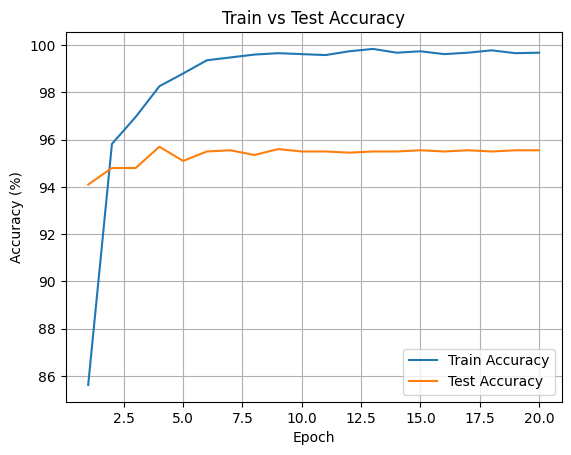

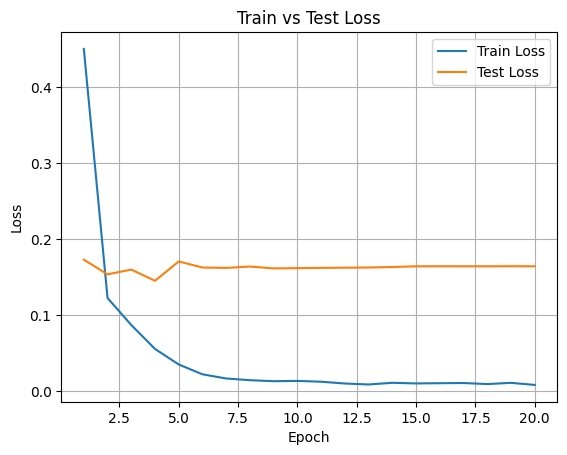

In [16]:
# 결과 시각화

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)


# Accuracy Plot

plt.figure()
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Loss Plot

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
best_epoch = test_accuracies.index(max(test_accuracies)) + 1
best_acc = max(test_accuracies)

print(f"Best Test Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")


Best Test Accuracy: 95.70% at Epoch 4
